# use lotus data to identify UC

In [ ]:
path_ljUcIcDEG = '/data/Zhaijx/liuzj/projects/singleCell/soybean/01_data/lj_pbj/lj_uc_ic.tsv'
path_ljGmOrth = '/data/Zhaijx/liuzj/data/ortholog/plant/parsed/1v1_soybean_maize_lotus/soybase_2__v__lotus.1v1.tsv'

In [ ]:
path_allGmOrth = '/data/Zhaijx/liuzj/data/ortholog/plant/results_soybean_maize_lotus/Results_Mar02/Orthologues/Orthologues_soybase_2/soybase_2__v__lotus.tsv'

In [ ]:
df_allGmOrth = pd.read_table(path_allGmOrth)
df_allGmOrth["lotus"] = df_allGmOrth["lotus"].str.split(',')
df_allGmOrth = df_allGmOrth.explode("lotus")
df_allGmOrth['lotus'] = df_allGmOrth['lotus'].map(lambda x: x.split('|')[1].split('.')[0])
def _fc(df):
    return ','.join(df['soybase_2'].to_list()).split(',') >> F(map, str.strip) >> F(map, lambda x: x.split('glyma.Wm82.gnm2.ann1.')[1].replace('Glyma.', 'GLYMA_').split('.')[0]) >> F(set) >> F(sorted) >> F(list)

In [ ]:
dt_allLj2Gm = df_allGmOrth.groupby("lotus").apply(_fc).to_dict()

In [ ]:
df_ljDeg = pd.read_table(path_ljUcIcDEG)
df_ljGmOrth = pd.read_table(path_ljGmOrth)
dt_ljGmOrth = df_ljGmOrth.set_index('lotus')['soybase_2'].to_dict()

In [ ]:
ad_ifz = ad[ad.obs.eval("Cluster in ['0', '7', '11', '12']")].copy()

## 1v1 only

In [ ]:
df_ljDeg = (
    df_ljDeg.assign(
        gene=lambda df: df["Transcript ID \n(Lj 3.0)"].str.split(".").str[0]
    )
    .assign(gmGene=lambda df: df["gene"].map(dt_ljGmOrth))
    .dropna(subset=["gmGene"])
)
df_ljDeg = df_ljDeg.rename(columns = lambda x:x.replace('\n', '_'))
df_ljDeg['-log10FDR'] = - np.log10(df_ljDeg['FDR'])
df_ljDeg = df_ljDeg.query("`-log10FDR` > 4 & (`Log2FC_(IC vs UC)` < -10 | `Log2FC_(IC vs UC)` > 10)")

In [ ]:
df_ljDeg = df_ljDeg.pipe(
    lambda df: df.assign(category=np.where(df["Log2FC_(IC vs UC)"] > 0, "IC", "UC"))
)

In [ ]:
df_ljDeg_1 = df_ljDeg

In [ ]:
dt_ljDeg = df_ljDeg.query('gmGene in @ad.var.index').groupby('category')['gmGene'].agg(list).to_dict()

In [ ]:
dt_ljDeg = {x: dt_ljDeg[x] for x in ["UC", "IC"]}

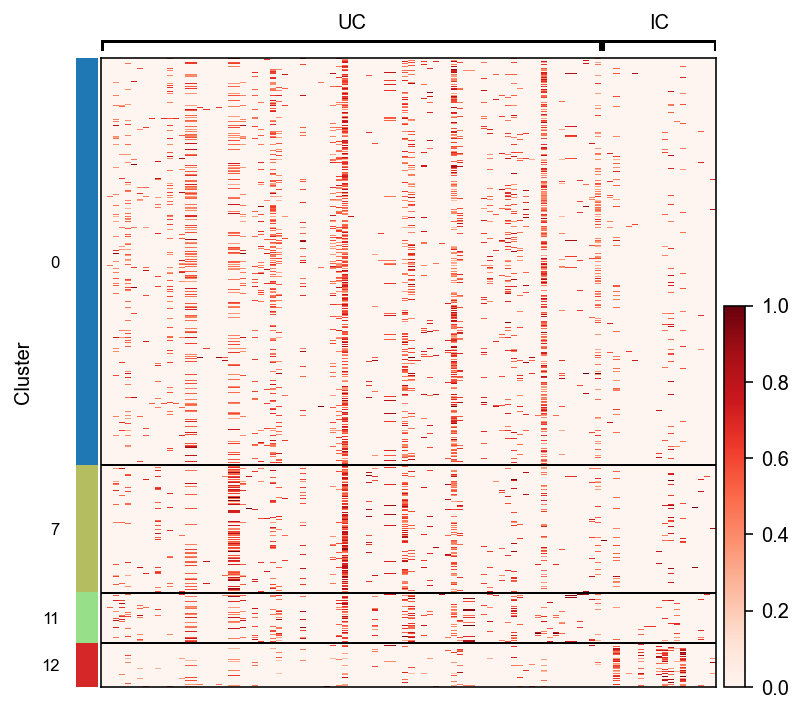

In [ ]:
sc.pl.heatmap(
    ad_ifz,
    dt_ljDeg,
    "Cluster",
    cmap="Reds",
    layer="normalize_log",
    standard_scale="var",
    figsize=(6, 6),
)

R[write to console]: Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



    min      1%      5%     10%     50%    100% 
 460.00  657.07  742.00  799.00 1246.00 3613.00 


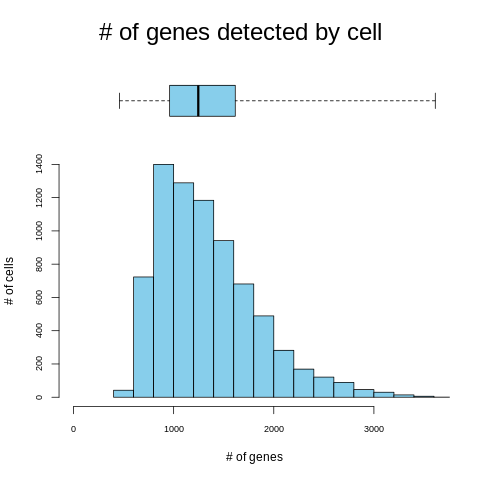

In [ ]:
singleCellTools.geneEnrichInfo.getAUCellScore_r(
    ad_ifz,
    dt_ljDeg,
    layer="raw",
)

In [ ]:
from matplotlib import ticker

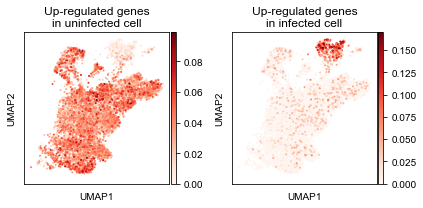

In [ ]:
ls_title = [
    "Up-regulated genes\nin uninfected cell",
    "Up-regulated genes\nin infected cell",
]
with plt.rc_context({"figure.figsize": (6, 3)}):
    _ad = singleCellTools.plotting.obsmToObs(ad_ifz, "AUCell")
    fig, axs = plt.subplots(1, 2)
    axs = axs.reshape(-1)
    for label, title, ax in zip(_ad.uns["plot_obsm"], ls_title, axs):
        if label == "Cortex":
            sc.pl.umap(
                _ad, color=label, title=title, cmap="Reds", show=False, ax=ax, vmin=0.15
            )
        else:
            sc.pl.umap(_ad, color=label, title=title, cmap="Reds", show=False, ax=ax)
        plt.sca(ax)
        plt.xlim(3, 13)
    plt.tight_layout()

#### lj DEG in sc datasets

## all only

In [ ]:
df_ljDeg = pd.read_table(path_ljUcIcDEG)
df_ljGmOrth = pd.read_table(path_ljGmOrth)
dt_ljGmOrth = df_ljGmOrth.set_index('lotus')['soybase_2'].to_dict()

In [ ]:
df_ljDegAll = (
    df_ljDeg.assign(
        gene=lambda df: df["Transcript ID \n(Lj 3.0)"].str.split(".").str[0]
    )
    .assign(gmGene=lambda df: df["gene"].map(dt_allLj2Gm))
    .dropna(subset=["gmGene"])
)
df_ljDegAll = df_ljDegAll.rename(columns = lambda x:x.replace('\n', '_'))
df_ljDegAll['-log10FDR'] = - np.log10(df_ljDegAll['FDR'])
df_ljDegAll = df_ljDegAll.query("`-log10FDR` > 4 & (`Log2FC_(IC vs UC)` < -10 | `Log2FC_(IC vs UC)` > 10)")

In [ ]:
df_ljDegAll = df_ljDegAll.pipe(
    lambda df: df.assign(category=np.where(df["Log2FC_(IC vs UC)"] > 0, "IC", "UC"))
)

In [ ]:
_ls = df_ljDeg_1['gene']
df_ljDegAll = df_ljDegAll.query("`gene` not in @_ls", engine='python').explode("gmGene")

In [ ]:
df_ljDegAll = pd.concat([df_ljDeg_1, df_ljDegAll])

In [ ]:
df_ljDegAll = df_ljDegAll.sort_values(['category', 'Transcript ID _(Lj 3.0)'])

In [ ]:
df_ljDegAll.to_excel(f"{dir_result}/ljDegAll.xlsx")

In [ ]:
dt_ljDegAll = df_ljDegAll.groupby('category')['gmGene'].agg(lambda x: list(set(x))).to_dict()

In [ ]:
dt_ljDegAll = {x: [z for z in y if z in ad.var.index] >> F(set) >> F(list) for x, y in dt_ljDegAll.items()}

In [ ]:
dt_ljDegAll = {x: dt_ljDegAll[x] for x in ["UC", "IC"]}

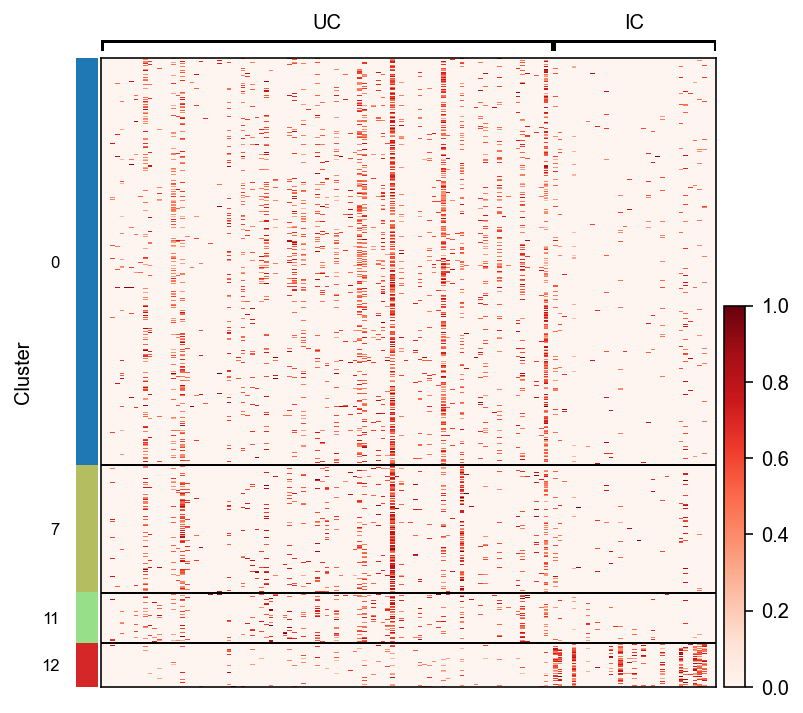

In [ ]:
sc.pl.heatmap(
    ad_ifz,
    dt_ljDegAll,
    "Cluster",
    cmap="Reds",
    layer="normalize_log",
    standard_scale="var",
    figsize=(6, 6),
)

R[write to console]: Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



    min      1%      5%     10%     50%    100% 
 460.00  657.07  742.00  799.00 1246.00 3613.00 


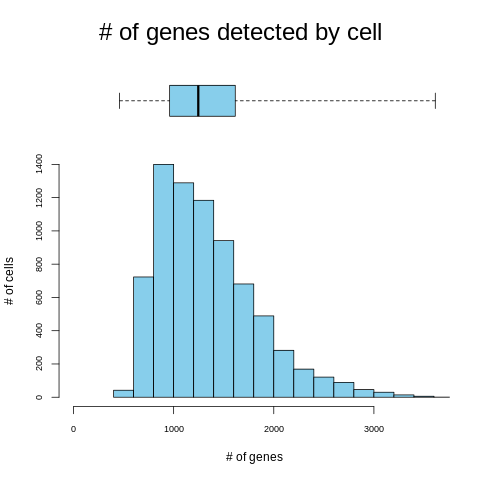

In [ ]:
singleCellTools.geneEnrichInfo.getAUCellScore_r(
    ad_ifz,
    dt_ljDegAll,
    layer="raw",
    label='all_ljDeg'
)

In [ ]:
from matplotlib import ticker

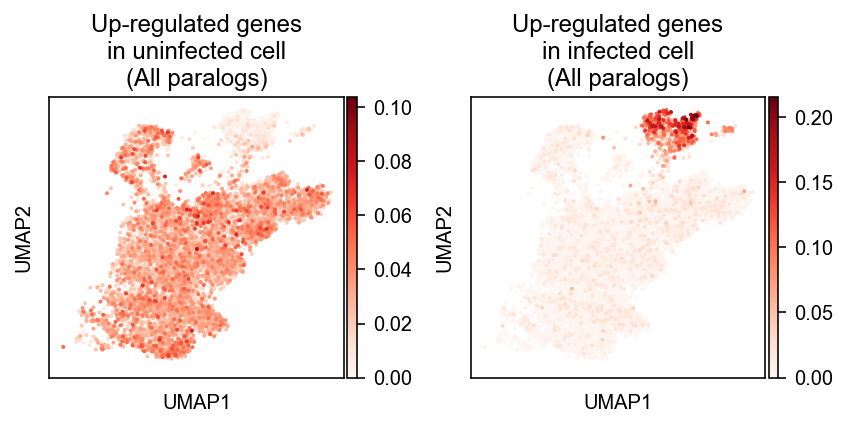

In [ ]:
ls_title = [
    "Up-regulated genes\nin uninfected cell\n(All paralogs)",
    "Up-regulated genes\nin infected cell\n(All paralogs)",
]
with plt.rc_context({"figure.figsize": (6, 3)}):
    _ad = singleCellTools.plotting.obsmToObs(ad_ifz, "all_ljDeg")
    fig, axs = plt.subplots(1, 2)
    axs = axs.reshape(-1)
    for label, title, ax in zip(_ad.uns["plot_obsm"], ls_title, axs):
        if label == "Cortex":
            sc.pl.umap(
                _ad, color=label, title=title, cmap="Reds", show=False, ax=ax, vmin=0.15
            )
        else:
            sc.pl.umap(_ad, color=label, title=title, cmap="Reds", show=False, ax=ax)
        plt.sca(ax)
        plt.xlim(3, 13)
    plt.tight_layout()

#### sc marker in lj

In [ ]:
df_ljGem = pd.read_excel('/data/Zhaijx/liuzj/projects/singleCell/soybean/01_data/lj_pbj/pbi13778-sup-0002-tables1 (1).xlsx')
df_ljGem = df_ljGem.assign(gene=lambda df: df["Transcript"].str.split(".").str[0]).drop(
    columns="Transcript"
).groupby("gene").agg("sum")

In [ ]:
df_ljGem = df_ljGem.loc[df_ljGem.index.isin(dt_ljGmOrth)]
df_ljGem.index = df_ljGem.index.map(dt_ljGmOrth)

In [ ]:
ad_lj = sc.AnnData(df_ljGem.T)
ad_lj.var_names_make_unique()

In [ ]:
ad_lj.layers['rpkm'] = ad_lj.X.copy()
ad_lj.obs["category"] = ["IC", "IC", "UC", "UC", "UC", "UC"]

In [ ]:
df_scMarker = ad.uns['Cell type_cellexES'].assign(
    Cluster=lambda df: df["Cell type"].str.split(":").str[0]
)

In [ ]:
df_scMarker["Cluster"] = df_scMarker["Cluster"].astype("category").cat.set_categories(
    ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14"]
)

In [ ]:
df_scMarker.query(
    "enrichScore > 0.75 & expressed_ratio > 0.1 & expressed_ratio / expressed_ratio_others > 2"
).merge(df_symbol, left_on="gene", right_index=True, how="left").sort_values(
    ["Cell type", "enrichScore"], ascending=[True, False]
).to_excel(f"{dir_result}/cluster_marker.xlsx")

In [ ]:
dt_scMarker = (
    df_scMarker.query(
        "enrichScore > 0.75 & expressed_ratio > 0.1 & expressed_ratio / expressed_ratio_others > 2 & gene in @ad_lj.var.index"
    )
    .groupby("Cluster")["gene"]
    .agg(list)
    .to_dict()
)

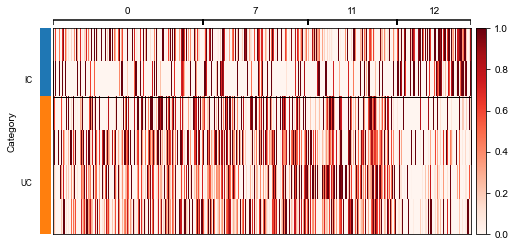

In [ ]:
axs = sc.pl.heatmap(
    ad_lj,
    {x: dt_scMarker[x] for x in ["0", "7", "11", "12"]},
    "category",
    cmap="Reds",
    standard_scale="var",
    figsize=(8, 4),
    show=False,
)
plt.sca(axs["groupby_ax"])
plt.ylabel("Category")
plt.show()

#### verification

In [ ]:
ls_gene = [
    "GLYMA_10G199100",
    "GLYMA_10G199000",
    "GLYMA_20G191200",
    "GLYMA_10G198800",
    "GLYMA_08G012800",
    "GLYMA_05G205900",
    "GLYMA_06G301500",
    "GLYMA_15G098100",
    "GLYMA_08G025500",
    "GLYMA_17G150100",
    "GLYMA_05G068000",
    "GLYMA_01G203400",
    "GLYMA_11G039400",
    "GLYMA_13G215000",
]
ls_name = [
    "LBA",
    "LBC1",
    "LBC2",
    "LBC3",
    "SYMREM1.1",
    "SYMREM1.2",
    "BMY1-1",
    "BMY1-2",
    "BMY1-3",
    "BMY2",
    "BMY3-1",
    "BMY3-2",
    "BMY3-3",
    "BMY9",
]

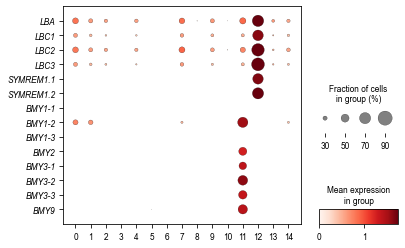

In [ ]:
axs = sc.pl.dotplot(
    ad,
    ls_gene,
    "Cluster",
    layer="normalize_log",
    cmap="Reds",
    swap_axes=True,
    show=False,
    figsize=(6, 4),
    dot_min=0.15,
    dot_max=0.9, vmax=1.75
)
plt.sca(axs["mainplot_ax"])
plt.xticks(rotation=0)
plt.yticks([x + 0.5 for x in range(len(ls_name))], ls_name, style="italic")
plt.show()

In [ ]:
{"SYMREM1.1": "GLYMA_08G012800", "N56": "GLYMA_13G024700", "ENOD55": "GLYMA_02G204500"}

{'SYMREM1.1': 'GLYMA_08G012800',
 'N56': 'GLYMA_13G024700',
 'ENOD55': 'GLYMA_02G204500'}

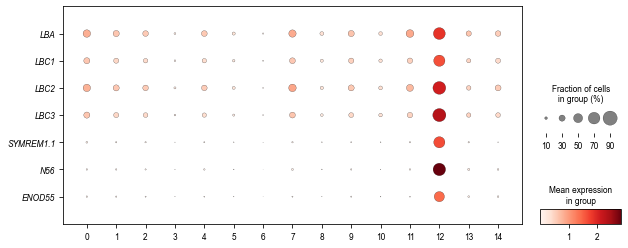

In [ ]:
ls_gene = [
    "GLYMA_10G199100",
    "GLYMA_10G199000",
    "GLYMA_20G191200",
    "GLYMA_10G198800",
    "GLYMA_08G012800",
    "GLYMA_13G024700",
    "GLYMA_02G204500",
]
ls_name = ["LBA", "LBC1", "LBC2", "LBC3", "SYMREM1.1", "N56", "ENOD55"]
axs = sc.pl.dotplot(
    ad,
    ls_gene,
    "Cluster",
    layer="normalize_log",
    cmap="Reds",
    swap_axes=True,
    show=False,
    figsize=(10, 4),
)
plt.sca(axs["mainplot_ax"])
plt.xticks(rotation=0)
plt.yticks([x + 0.5 for x in range(len(ls_name))], ls_name, style="italic")
plt.show()

In [ ]:
ls_gene = [
    "GLYMA_06G301500",
    "GLYMA_15G098100",
    "GLYMA_08G025500",
    "GLYMA_17G150100",
    "GLYMA_05G068000",
    "GLYMA_01G203400",
    "GLYMA_11G039400",
    "GLYMA_13G215000",
    "GLYMA_01G058500",
    "GLYMA_02G116300",
    "GLYMA_02G116400",
    "GLYMA_20G072400",
    "GLYMA_14G111800",
    "GLYMA_17G216000",
]
ls_name = [
    "BMY1-1",
    "BMY1-2",
    "BMY1-3",
    "BMY2",
    "BMY3-1",
    "BMY3-2",
    "BMY3-3",
    "BMY9",
    "UPS2-1",
    "UPS2-2",
    "UPS2-3",
    "UR2",
    "ASP5-1",
    "ASP5-2",
]

In [ ]:
ls_gene = [
    "GLYMA_15G098100",
    "GLYMA_17G150100",
    "GLYMA_05G068000",
    "GLYMA_01G203400",
    "GLYMA_11G039400",
    "GLYMA_13G215000",
    "GLYMA_01G058500",
    "GLYMA_02G116300",
    "GLYMA_20G072400",
    "GLYMA_14G111800",
    "GLYMA_17G216000",
]
ls_name = [
    "BMY1-2",
    "BMY2",
    "BMY3-1",
    "BMY3-2",
    "BMY3-3",
    "BMY9",
    "UPS2-1",
    "UPS2-2",
    "UR2",
    "ASP5",
    "ASP5",
]
ls_name = [f"{x}\n({y})" for x,y in zip(ls_gene, ls_name)]

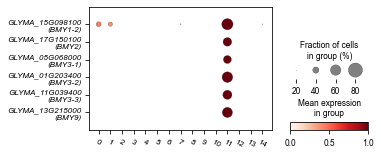

In [ ]:
axs = sc.pl.dotplot(
    ad,
    ls_gene[:6],
    "Cluster",
    layer="normalize_log",
    cmap="Reds",
    swap_axes=True,
    show=False,
    figsize=(5, 5 / 11 * 5),
    dot_min=0.2,
    dot_max=0.8,
    standard_scale="var",
)
plt.sca(axs["mainplot_ax"])
plt.yticks([x + 0.5 for x in range(len(ls_name[:6]))], ls_name[:6], style="italic", size=8)
plt.xticks(rotation=-30, ha="center", size=8)
plt.show()

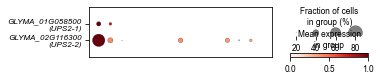

In [ ]:
axs = sc.pl.dotplot(
    ad,
    ls_gene[6:8],
    "Cluster",
    layer="normalize_log",
    cmap="Reds",
    swap_axes=True,
    show=False,
    figsize=(5, 2 / 11 * 5),
    dot_min=0.2,
    dot_max=0.8,
    standard_scale="var",
)
plt.sca(axs["mainplot_ax"])
plt.yticks([x + 0.5 for x in range(len(ls_name[6:8]))], ls_name[6:8], style="italic", size=8)
plt.xticks([])
plt.tick_params(bottom=False)
plt.show()

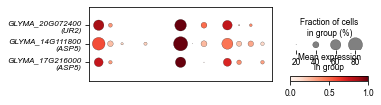

In [ ]:
axs = sc.pl.dotplot(
    ad,
    ls_gene[8:],
    "Cluster",
    layer="normalize_log",
    cmap="Reds",
    swap_axes=True,
    show=False,
    figsize=(5, 3 / 11 * 5),
    dot_min=0.2,
    dot_max=0.8,
    standard_scale="var",
)
plt.sca(axs["mainplot_ax"])
plt.yticks([x + 0.5 for x in range(len(ls_name[8:]))], ls_name[8:], style="italic", size=8)
plt.xticks([])
plt.tick_params(bottom=False)
plt.show()

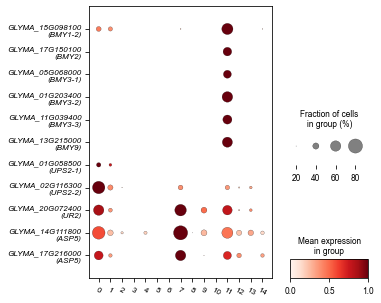

In [ ]:
axs = sc.pl.dotplot(
    ad,
    ls_gene,
    "Cluster",
    layer="normalize_log",
    cmap="Reds",
    swap_axes=True,
    show=False,
    figsize=(5, 5),
    dot_min=0.2,
    dot_max=0.8,
    standard_scale="var",
)
plt.sca(axs["mainplot_ax"])
plt.xticks(rotation=-30, ha="center", size=8)
plt.yticks([x + 0.5 for x in range(len(ls_name))], ls_name, style="italic", size=8)
plt.show()

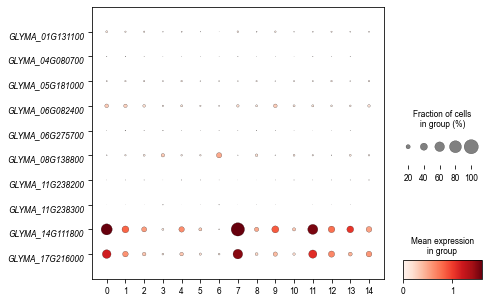

In [ ]:
# aspartate aminotransferase
_ls = (
    """Glyma.01g131100
Glyma.04g080700
Glyma.05g181000
Glyma.06g082400
Glyma.06g275700
Glyma.08g138800
Glyma.11g238200
Glyma.11g238300
Glyma.14g111800
Glyma.17g216000""".split()
    | F(map, lambda x: x.replace("Glyma.", "GLYMA_").upper())
    | F(list)
)
_ls_name = _ls[:]
# _ls_name[-2] = "GLYMA_14G111800\n(ASP5-1)"
# _ls_name[-1] = "GLYMA_17G216000\n(ASP5-2)"

axs = sc.pl.dotplot(
    ad,
    _ls,
    "Cluster",
    layer="normalize_log",
    cmap="Reds",
    swap_axes=True,
    show=False,
    figsize=(7, 5),
    vmax=1.6,
)
plt.sca(axs["mainplot_ax"])
plt.yticks([x + 0.5 for x in range(len(_ls))], _ls_name, style="italic", rotation=0, va='top')
plt.xticks(rotation=0)
plt.show()

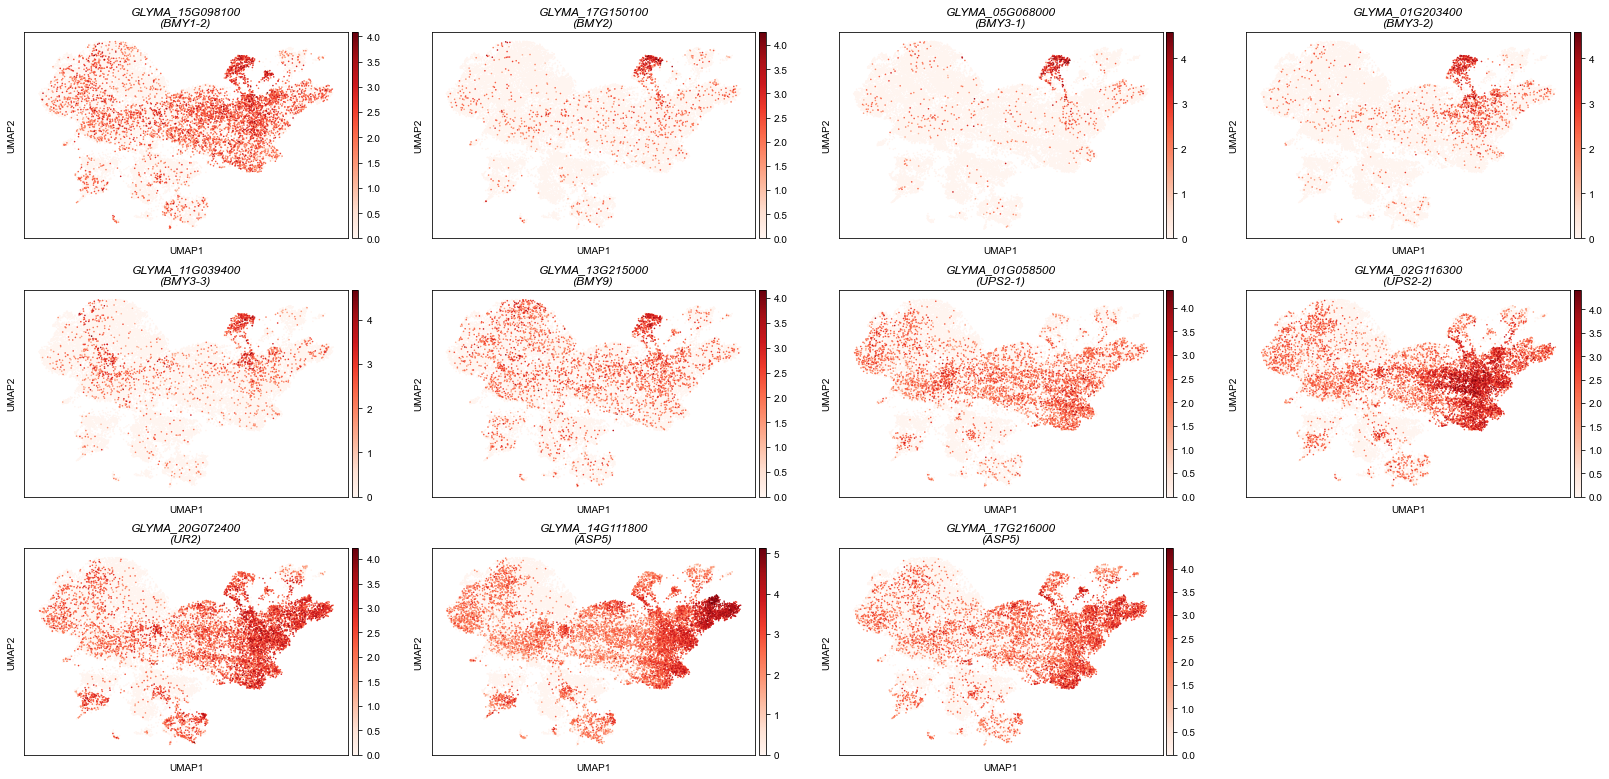

In [ ]:
axs = sc.pl.umap(
    ad,
    layer="normalize_log",
    cmap="Reds",
    color=ls_gene,
    title=ls_name,
    size=10, show=False, ncols=4
)
for ax in axs:
    plt.sca(ax)
    text = ax.get_title()
    plt.title(text, fontdict={'style': 'italic'})

In [ ]:
ls_gene = [
    "GLYMA_08G012800",
    "GLYMA_05G205900",
]
ls_name = [
    "SYMREM1.1",
    "SYMREM1.2",
]

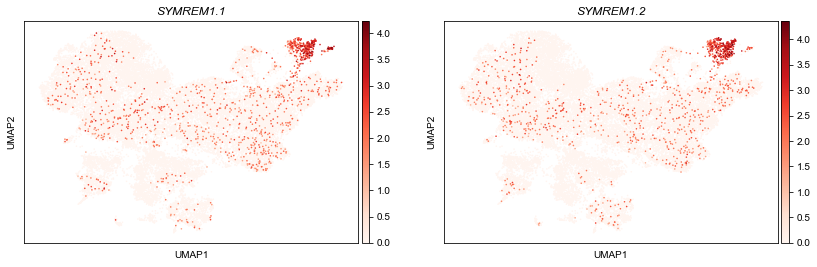

In [ ]:
axs = sc.pl.umap(
    ad,
    layer="normalize_log",
    cmap="Reds",
    color=ls_gene,
    title=ls_name,
    size=10, show=False
)
for ax in axs:
    plt.sca(ax)
    text = ax.get_title()
    plt.title(text, fontdict={'style': 'italic'})

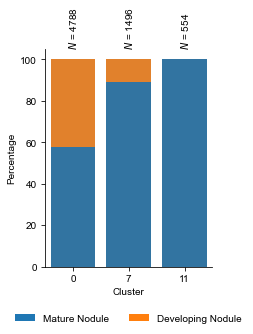

In [ ]:
with plt.rc_context({"figure.figsize": (3, 4)}):
    _ls = ["0", "7", "11"]
    singleCellTools.plotting.plotLabelPercentageInCluster(
        ad[ad.obs.eval("Cluster in @_ls & Sample != 'Root'")],
        "Cluster",
        "Sample_new",
        dt_kwargsForLegend={
            "bbox_to_anchor": [0.5, -0.3],
            "loc": "lower center",
            "ncol": 2,
        },
    )

In [ ]:
ls_gene = [
    "GLYMA_06G301500",
    "GLYMA_15G098100",
    "GLYMA_08G025500",
    "GLYMA_17G150100",
    "GLYMA_05G068000",
    "GLYMA_01G203400",
    "GLYMA_11G039400",
    "GLYMA_13G215000",
]
ls_name = [
    "BMY1-1",
    "BMY1-2",
    "BMY1-3",
    "BMY2",
    "BMY3-1",
    "BMY3-2",
    "BMY3-3",
    "BMY9",
]

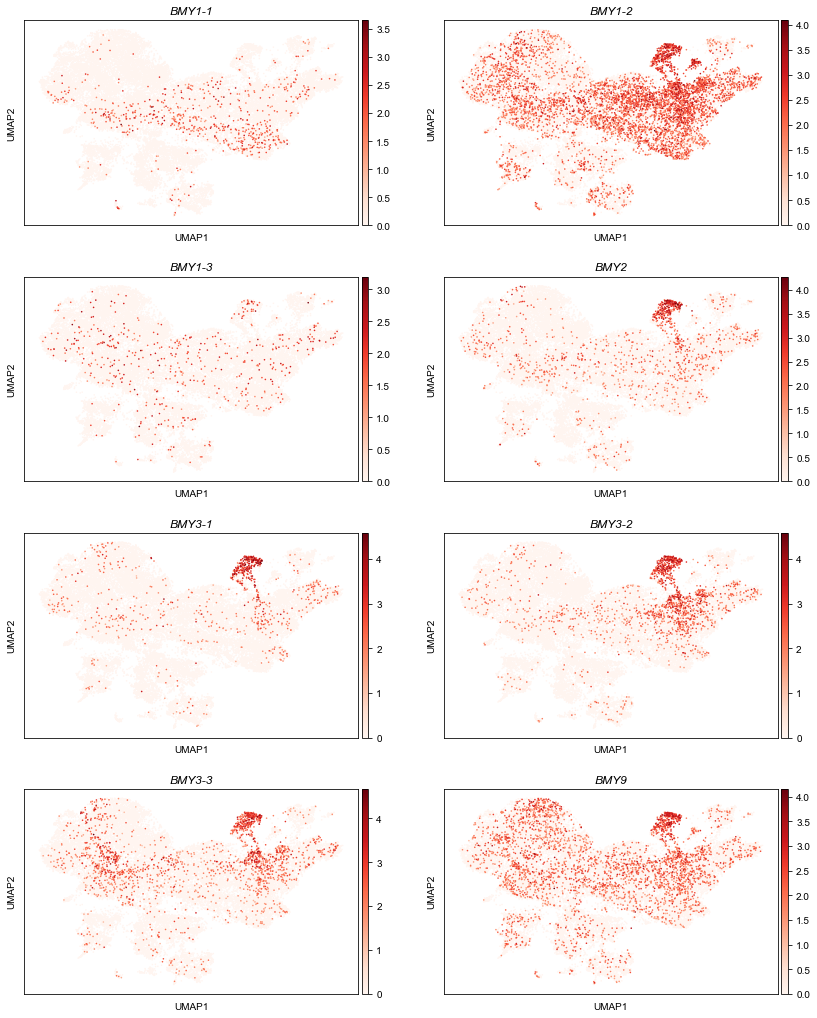

In [ ]:
axs = sc.pl.umap(
    ad,
    layer="normalize_log",
    cmap="Reds",
    color=ls_gene,
    title=ls_name,
    ncols=2,
    size=10,
    show=False,
)
for ax in axs:
    plt.sca(ax)
    text = ax.get_title()
    plt.title(text, fontdict={"style": "italic"})